## Install and Import Dependencies

In [7]:
#Install torch-new version
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Here we are downloading 3 different models -
  1) Transformers - Used for importing the NLP model- Bert-Base-Multilingual-Sentiment
  2) requestes - Used for scrapping the data 
  3) beautifulsoup4 - Used for extracting the data from a particular page 


In [8]:
#!pip install transformers requests beautifulsoup4

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch 
import requests 
from bs4 import BeautifulSoup
import re # regex function

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use('ggplot')   # style sheet for plotting

import nltk 

## Data Pre-Processing

In [2]:
# Read the data 
data = pd.read_csv(r"F:\ML_Practice\NLP\Sentiment Analysis Twitter\Twitter_Data.csv")
data = data.head(1000)

In [3]:
data = pd.DataFrame(data)

In [4]:
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [26]:
data['category'] = data['category'].replace(-1, 2)

In [5]:
print("Shape of the data - ", data.shape)

Shape of the data -  (1000, 2)


In [6]:
# NaN values

data['category'].isna().value_counts()
#data = data.dropna()

category
False    1000
Name: count, dtype: int64

In [7]:
print(data.dtypes)

clean_text     object
category      float64
dtype: object


#### Quick EDA

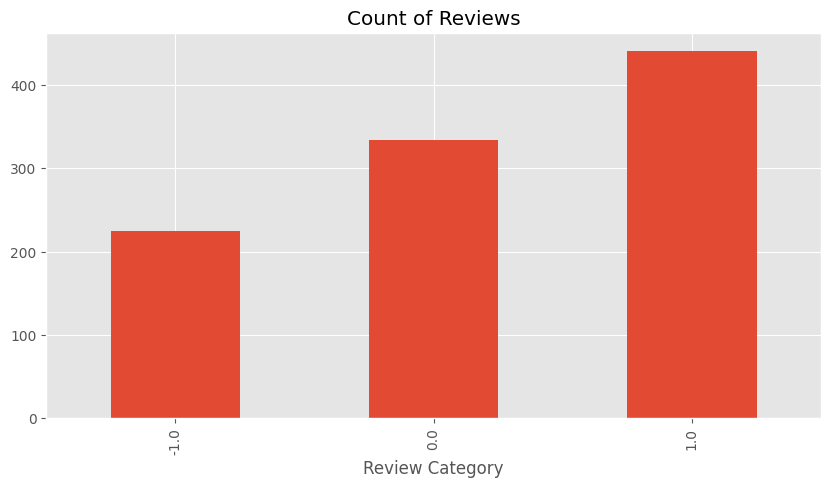

In [146]:
plot = data['category'].value_counts().sort_index().plot(
    kind='bar',title='Count of Reviews',figsize=(10,5))
plot.set_xlabel('Review Category')
plt.show()

### NLTK Pre-Processing

In [14]:
exmp = data['clean_text'][95]
exmp

'country prospers when the women the country are leading the forefront are supported every endeavour their lives modi govt focussed policies where women have been enabled with the power empower themselves and the nation\nvia namo app'

In [15]:
tokens = nltk.word_tokenize(exmp)
tokens

['country',
 'prospers',
 'when',
 'the',
 'women',
 'the',
 'country',
 'are',
 'leading',
 'the',
 'forefront',
 'are',
 'supported',
 'every',
 'endeavour',
 'their',
 'lives',
 'modi',
 'govt',
 'focussed',
 'policies',
 'where',
 'women',
 'have',
 'been',
 'enabled',
 'with',
 'the',
 'power',
 'empower',
 'themselves',
 'and',
 'the',
 'nation',
 'via',
 'namo',
 'app']

## Vader Sentiment Scoring  

Vader - Valence Aware Dictionary and Sentiment Reasoner

It assigns a polarity score to input text, indicating the sentiment aspositive,negative, or neutral, along with a compound score that combines all three.

In [16]:
from nltk.sentiment import SentimentIntensityAnalyzer 
from tqdm.notebook import tqdm 

sia = SentimentIntensityAnalyzer()

In [17]:
sia.polarity_scores(exmp)

{'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compound': 0.3182}

In [18]:
# Run the polarity score on entire dataset 

vader_text = {}
for j,row in tqdm(data.iterrows(),total=len(data)):
    text = row['clean_text']
    vader_text[j] = sia.polarity_scores(text)
    

  0%|          | 0/999 [00:00<?, ?it/s]

In [19]:
vader_text_df = pd.DataFrame(vader_text).T 
vader_text_df.reset_index()
vader_text_df = pd.concat([pd.DataFrame(data),vader_text_df],axis=1)
vader_text_df.head()

,clean_text,category,neg,neu,pos,compound
0,when modi promised “minimum government maximum...,-1.0,0.065,0.781,0.154,0.5267
1,talk all the nonsense and continue all the dra...,0.0,0.184,0.816,0.000,-0.4019
2,what did just say vote for modi welcome bjp t...,1.0,0.000,0.772,0.228,0.7096
3,asking his supporters prefix chowkidar their n...,1.0,0.187,0.655,0.158,-0.0713
4,answer who among these the most powerful world...,1.0,0.000,0.808,0.192,0.4754


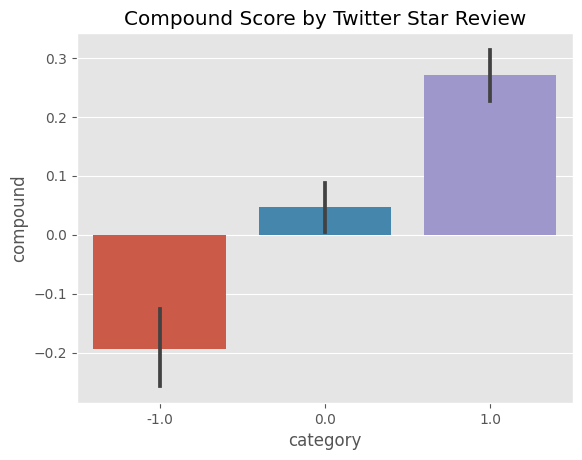

In [20]:
# Plotting Vadder Results
ax = sns.barplot(data=vader_text_df,x='category',y='compound')
ax.set_title('Compound Score by Twitter Star Review')
plt.show()

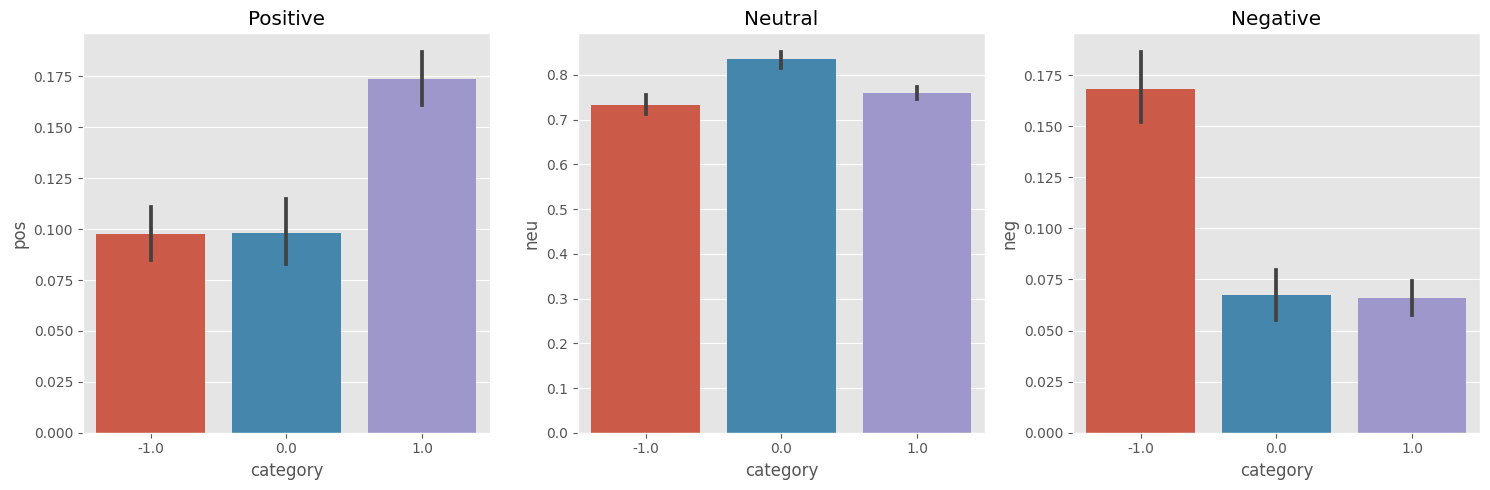

In [21]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vader_text_df,x='category',y='pos',ax=axs[0])
sns.barplot(data=vader_text_df,x='category',y='neu',ax=axs[1])
sns.barplot(data=vader_text_df,x='category',y='neg',ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

Some disadvantages of the VADER model in NLP:
   1) Limited context understanding, as it doesn't consider word relationships or nuances in meaning.
   2) Difficulty in handling sarcasm or irony due to its rule-based nature.

These limitations have led to the adoption of advanced models like BERT

## Bert Pretrained Model 

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, pipeline
from scipy.special import softmax  #  for applying softmax at o/p

In [23]:
# vader results on example 
print(exmp)
sia.polarity_scores(exmp)

country prospers when the women the country are leading the forefront are supported every endeavour their lives modi govt focussed policies where women have been enabled with the power empower themselves and the nation
via namo app


{'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compound': 0.3182}

In [24]:
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis") #same as 'avichr/heBERT' tokenizer
model = AutoModel.from_pretrained("avichr/heBERT_sentiment_analysis")

# how to use?
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="avichr/heBERT_sentiment_analysis",
    tokenizer="avichr/heBERT_sentiment_analysis",
    return_all_scores = True
)

C:\Users\Ruchita Gayatri\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
output

In [26]:
bert_text = {}
for j,row in tqdm(data.iterrows(),total=len(data)):
    text = row['clean_text']
    bert_text[j] = sentiment_analysis(text)
    

  0%|          | 0/999 [00:00<?, ?it/s]

In [29]:
bert_text_df['tar'] = pd.DataFrame(bert_text).T 
bert_text_df.reset_index()
bert_text_df = pd.concat([pd.DataFrame(data),bert_text_df],axis=1)
bert_text_df.head()

,clean_text,category,clean_text,category,0,tar
0,when modi promised “minimum government maximum...,-1.0,when modi promised “minimum government maximum...,-1.0,"[{'label': 'neutral', 'score': 0.1271052956581...","[{'label': 'neutral', 'score': 0.1271052956581..."
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...,0.0,"[{'label': 'neutral', 'score': 0.9944126009941...","[{'label': 'neutral', 'score': 0.9944126009941..."
2,what did just say vote for modi welcome bjp t...,1.0,what did just say vote for modi welcome bjp t...,1.0,"[{'label': 'neutral', 'score': 0.9917028546333...","[{'label': 'neutral', 'score': 0.9917028546333..."
3,asking his supporters prefix chowkidar their n...,1.0,asking his supporters prefix chowkidar their n...,1.0,"[{'label': 'neutral', 'score': 0.0017472134204...","[{'label': 'neutral', 'score': 0.0017472134204..."
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...,1.0,"[{'label': 'neutral', 'score': 0.2075325250625...","[{'label': 'neutral', 'score': 0.2075325250625..."


In [40]:
positive_scores_bert = []
negative_scores_bert = []
neutral_scores_bert = []

for key in range(len(bert_text_df['tar'])):
    try:
        positive_scores_bert.append(bert_text_df['tar'][key][0]['score'])
    except KeyError:
        pass

    try:
        neutral_scores_bert.append(bert_text_df['tar'][key][1]['score'])
    except KeyError:
        pass

    try:
        negative_scores_bert.append(bert_text_df['tar'][key][2]['score'])
    except KeyError:
        pass

df = pd.DataFrame({
    'positive_score': positive_scores_bert,
    'neutral_score': neutral_scores_bert,
    'negative_score': negative_scores_bert
})

     positive_score  neutral_score  negative_score
0          0.127105       0.000424        0.872471
1          0.994413       0.001995        0.003592
2          0.991703       0.002122        0.006175
3          0.001747       0.000092        0.998160
4          0.207533       0.784431        0.008036
..              ...            ...             ...
993        0.000150       0.000076        0.999774
994        0.010876       0.000183        0.988941
995        0.997881       0.001374        0.000745
996        0.973897       0.001072        0.025031
997        0.998949       0.000491        0.000560

[998 rows x 3 columns]


In [41]:
#bert_text_df = pd.DataFrame(bert_text).T 
#bert_text_df.reset_index()
bert_text_df1 = pd.concat([pd.DataFrame(data), df],axis=1)
bert_text_df1.head()

,clean_text,category,positive_score,neutral_score,negative_score
0,when modi promised “minimum government maximum...,-1.0,0.127105,0.000424,0.872471
1,talk all the nonsense and continue all the dra...,0.0,0.994413,0.001995,0.003592
2,what did just say vote for modi welcome bjp t...,1.0,0.991703,0.002122,0.006175
3,asking his supporters prefix chowkidar their n...,1.0,0.001747,0.000092,0.998160
4,answer who among these the most powerful world...,1.0,0.207533,0.784431,0.008036


In [43]:
# Assuming the dataframe is named 'df'
# Calculate the assigned label based on the maximum score
bert_text_df1['predicted_label'] = bert_text_df1[['positive_score', 'neutral_score', 'negative_score']].idxmax(axis=1)
bert_text_df1['predicted_label'] = bert_text_df1['predicted_label'].map({'positive_score': 1, 'neutral_score': 0, 'negative_score': -1})

# Calculate accuracy
accuracy = (bert_text_df1['category'] == bert_text_df1['predicted_label']).sum() / len(bert_text_df1)

print(f"Accuracy: {accuracy}")

Accuracy: 356


In [53]:
bert_text_df1

,clean_text,category,positive_score,neutral_score,negative_score,predicted_label
0,when modi promised “minimum government maximum...,-1.0,0.127105,0.000424,0.872471,-1.0
1,talk all the nonsense and continue all the dra...,0.0,0.994413,0.001995,0.003592,1.0
2,what did just say vote for modi welcome bjp t...,1.0,0.991703,0.002122,0.006175,1.0
3,asking his supporters prefix chowkidar their n...,1.0,0.001747,0.000092,0.998160,-1.0
4,answer who among these the most powerful world...,1.0,0.207533,0.784431,0.008036,0.0
...,...,...,...,...,...,...
996,there are two reasons for atmosphere hatred cr...,0.0,0.973897,0.001072,0.025031,1.0
997,modi has wiped out the small micro industries ...,-1.0,0.998949,0.000491,0.000560,1.0
998,bjp struggles find candidates west bengal graf...,-1.0,NaN,NaN,NaN,NaN
999,modis opposition trying defame him they not wa...,-1.0,NaN,NaN,NaN,NaN


## Transformers Roberto Model

In [45]:
name = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(name) #same as 'avichr/heBERT' tokenizer
model = AutoModelForSequenceClassification.from_pretrained(name)

C:\Users\Ruchita Gayatri\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ruchita Gayatri\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [61]:
def polarity_roberta_model(exmp):
    encoded_text = tokenizer(exmp,return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [65]:
res = {}
for i in range(len(data['clean_text'])):
    try:
        text = data['clean_text'][i]
        roberta_result = polarity_roberta_model(text)
        res[i] = roberta_result
    except KeyError:
        pass

In [71]:
res[0]

{'roberta_neg': 0.50993735,
 'roberta_neu': 0.45967558,
 'roberta_pos': 0.03038706}

In [73]:
positive_scores_roberto = []
negative_scores_roberto = []
neutral_scores_roberto = []

for key in range(len(res)):
    try:
        positive_scores_roberto.append(res[key]['roberta_pos'])
    except KeyError:
        pass

    try:
        neutral_scores_roberto.append(res[key]['roberta_neu'])
    except KeyError:
        pass

    try:
        negative_scores_roberto.append(res[key]['roberta_neg'])
    except KeyError:
        pass

df_roberto = pd.DataFrame({
    'positive_score': positive_scores_roberto,
    'neutral_score': neutral_scores_roberto,
    'negative_score': negative_scores_roberto
})

In [74]:
roberta_text_df1 = pd.concat([pd.DataFrame(data), df_roberto],axis=1)
roberta_text_df1.head()

,clean_text,category,positive_score,neutral_score,negative_score
0,when modi promised “minimum government maximum...,-1.0,0.030387,0.459676,0.509937
1,talk all the nonsense and continue all the dra...,0.0,0.021304,0.291328,0.687368
2,what did just say vote for modi welcome bjp t...,1.0,0.104743,0.755941,0.139316
3,asking his supporters prefix chowkidar their n...,1.0,0.033484,0.346615,0.619901
4,answer who among these the most powerful world...,1.0,0.409449,0.571666,0.018885


In [76]:
# Assuming the dataframe is named 'df'
# Calculate the assigned label based on the maximum score
roberta_text_df1['predicted_label'] = roberta_text_df1[['positive_score', 'neutral_score', 'negative_score']].idxmax(axis=1)
roberta_text_df1['predicted_label'] = roberta_text_df1['predicted_label'].map({'positive_score': 1, 'neutral_score': 0, 'negative_score': -1})

# Calculate accuracy
accuracy = (roberta_text_df1['category'] == roberta_text_df1['predicted_label']).sum() / len(roberta_text_df1)

print(f"Accuracy: {accuracy}")

Accuracy: 0.34


## Bert Sentiment Model

In [77]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [84]:
def bert(exmp):
    tokens = tokenizer.encode(exmp,return_tensors='pt')
    result = model(tokens)
    result1 = result[0][0].detach().numpy()
    return result1

In [83]:
result[0][0].detach().numpy()[0]

-1.578875

In [86]:
res1 = {}
for i in range(len(data['clean_text'])):
    try:
        text = data['clean_text'][i]
        bert_result = bert(text)
        res1[i] = bert_result
    except KeyError:
        pass

In [91]:
star1_score_bert = []
star2_score_bert = []
star3_score_bert = []
star4_score_bert = []
star5_score_bert = []

for key in range(len(res1)):
    try:
        star1_score_bert.append(res1[key][0])
    except KeyError:
        pass

    try:
        star2_score_bert.append(res1[key][1])
    except KeyError:
        pass

    try:
        star3_score_bert.append(res1[key][2])
    except KeyError:
        pass

    try:
        star4_score_bert.append(res1[key][3])
    except KeyError:
        pass

    try:
        star5_score_bert.append(res1[key][4])
    except KeyError:
        pass

df_bert = pd.DataFrame({
    '1star_score': star1_score_bert,
    '2star_score': star2_score_bert,
    '3star_score': star3_score_bert,
    '4star_score': star4_score_bert,
    '5star_score': star5_score_bert
})

In [92]:
df_bert

,1star_score,2star_score,3star_score,4star_score,5star_score
0,1.750037,1.344773,0.394932,-1.174564,-1.834382
1,1.003663,0.046509,-0.525930,-0.473757,-0.085566
2,0.586319,0.165690,-0.058456,-0.405370,-0.377055
3,0.823371,0.337463,0.207459,-0.385745,-0.786727
4,0.226172,-0.798734,-0.673237,-0.274797,1.244121
...,...,...,...,...,...
992,0.095604,-0.218022,-0.193373,-0.218324,0.434707
993,-0.235491,-0.323501,-0.272553,0.108405,0.461979
994,0.902311,0.838507,-0.003941,-0.665570,-1.049374
995,2.081190,1.579539,0.349281,-1.194563,-2.209444


In [93]:
bert_text_df1 = pd.concat([pd.DataFrame(data), df_bert],axis=1)
bert_text_df1.head()

,clean_text,category,1star_score,2star_score,3star_score,4star_score,5star_score
0,when modi promised “minimum government maximum...,-1.0,1.750037,1.344773,0.394932,-1.174564,-1.834382
1,talk all the nonsense and continue all the dra...,0.0,1.003663,0.046509,-0.525930,-0.473757,-0.085566
2,what did just say vote for modi welcome bjp t...,1.0,0.586319,0.165690,-0.058456,-0.405370,-0.377055
3,asking his supporters prefix chowkidar their n...,1.0,0.823371,0.337463,0.207459,-0.385745,-0.786727
4,answer who among these the most powerful world...,1.0,0.226172,-0.798734,-0.673237,-0.274797,1.244121


In [94]:
# Assuming the dataframe is named 'df'
# Calculate the assigned label based on the maximum score
bert_text_df1['predicted_label'] = bert_text_df1[['1star_score', '2star_score', '3star_score', '4star_score', '5star_score']].idxmax(axis=1)
bert_text_df1['predicted_label'] = bert_text_df1['predicted_label'].map({'1star_score': -1, '2star_score': -1, '3star_score': 0, '4star_score': 1, '5star_score': 1})

# Calculate accuracy
accuracy = (bert_text_df1['category'] == bert_text_df1['predicted_label']).sum() / len(bert_text_df1)

print(f"Accuracy: {accuracy}")


Accuracy: 0.337


## Distil Bert Model 

Steps included - 
   1) Call the Pre-Trained Model (DistilBert)
   2) Call the Tokenizer 
   3) Convert the encodings into Dataset objects 

In [27]:
X = data["clean_text"].to_list()
y = data["category"].to_list()

In [28]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Keep some data for inference (testing)
X_train1, X_test, y_train1, y_test = train_test_split(X_train, y_train, test_size=0.05, random_state=0)

In [29]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [30]:
X_train1 = [str(item) for item in X_train1]
X_val = [str(item) for item in X_val]

train_encodings = tokenizer(X_train1, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [16]:
train_encodings

{'input_ids': [[101, 3531, 5271, 2125, 2256, 3224, 3531, 2191, 2634, 5532, 5227, 2035, 20209, 3211, 7662, 2015, 2034, 4047, 4044, 2077, 2505, 2842, 2123, 2102, 29454, 10421, 1996, 4372, 2615, 4277, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2299, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 12338, 2001, 5637, 2515, 16913, 2072, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4315, 3286, 2191, 2047, 2634, 1998, 2191, 2256, 2406, 3565, 2373, 2088, 2021, 2035, 2023, 14

In [31]:
import tensorflow as tf 

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),y_train1))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings),y_val))

In [33]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer,TFTrainingArguments
# tft are used for training model . TFTTrainer is for predictions

training_args = TFTrainingArguments(
    output_dir = './results',          # o/p directory
    num_train_epochs = 3,              # training epochs 
    per_device_train_batch_size = 16,  # batch size per device during trainig 
    per_device_eval_batch_size = 64,   # batch size for evaluation 
    warmup_steps = 500,                # no. of warmup steps for learning rate scheduler
    eval_steps=100 , 
    weight_decay = 0.01,               # strength of weight decay 
    logging_dir = './logs',            # directory for storing logs 
    logging_steps = 10,
    evaluation_strategy="steps",
)

In [34]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)

trainer = TFTrainer(
    model = model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [50]:
model1 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [51]:
model1.fit(train_dataset.shuffle(100).batch(16), epochs=3, batch_size=16,
          validation_data=test_dataset.shuffle(100).batch(16))

Epoch 1/3
48/48 [==============================] - 412s 8s/step - loss: 2.3831 - accuracy: 0.3316 - val_loss: 1.0986 - val_accuracy: 0.3300
Epoch 2/3
48/48 [==============================] - 357s 7s/step - loss: 1.0986 - accuracy: 0.3342 - val_loss: 1.0986 - val_accuracy: 0.3300
Epoch 3/3
48/48 [==============================] - 468s 10s/step - loss: 1.0986 - accuracy: 0.3342 - val_loss: 1.0986 - val_accuracy: 0.3300


In [35]:
trainer.evaluate()

{'eval_loss': 0.9424633979797363}